In [1]:
import sys
import os
import toml

import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format

    import numpy as np
import scipy.optimize as SciOpt
from scipy.special import rel_entr
from tqdm.notebook import tqdm
from copy import deepcopy

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
# mpl.rcParams["font.family"] = 'serif'
# mpl.rc('text', usetex=True)
# plt.rcParams["mathtext.fontset"] = "dejavuserif"
plt.rcParams.update(
    {
        # "text.usetex": True,
        "text.latex.preamble": r"\usepackage{bm}",
        # Enforce default LaTeX font.
        "font.family": "serif",
        "mathtext.fontset": "dejavuserif",
    }
)

sys.path.append(os.path.join(sys.path[0], '../..'))

from data.io import Reader
from data.data_generators import DataGenerator
from lsm.lsmtype import Policy
import lsm.cost as CostFunc
import lsm.solver as Solvers

In [211]:
config = Reader.read_config('../../endure.toml')
data_gen = DataGenerator(config)
wls = config['workloads']
models = ['Robust', 'Nominal', 'Dostoevsky', 'Lazy Level', 'FluidLSM']
markers = ['o', 'x', '+', 'd', '*']
markers = {model: marker for model, marker in zip(models, markers)}
colors = ['tab:green', 'tab:gray', 'tab:orange', 'tab:blue', 'tab:purple']
colors = {model: color for model, color in zip(models, colors)}

In [212]:
VIZ_DIR = '/Users/ndhuynh/sandbox/viz'
RHO = 2
ROBUST_DF = pd.read_csv('/Users/ndhuynh/sandbox/data/workload_uncertainty_tunings.csv')

In [213]:
cf = CostFunc.EndureLevelCost(config)
cf_l = CostFunc.EndureLevelTrueCost(config)
cf(0.25, 2, 0.25, 0.25, 0.25, 0.25), cf_l(0.25, 2, 0.25, 0.25, 0.25, 0.25)

(5.208022498217016, 4.786460406903795)

In [214]:
def get_nominal_tunings(workload):
    tunings = {model: get_nominal_tuning(workload, model=model) for model in models}
    return tunings

def get_nominal_tuning(workload, model='K'):
    solvers = {
        'Robust': Solvers.EndureLevelSolver,
        'Dostoevsky': Solvers.EndureDostoevskyFixedSolver,
        'Lazy Level': Solvers.EndureLazyLevelingSolver,
        'Y1': Solvers.EndureYSolver,
        'FluidLSM': Solvers.EndureYZSolver,
        'Q': Solvers.EndureQSolver,
        'K': Solvers.EndureKSolver,
        'Tier': Solvers.EndureTierSolver,
        'Nominal': Solvers.EndureLevelSolver,
        'Level': Solvers.EndureLevelSolver}
    z0, z1, q, w = np.array([workload[key] for key in ('z0', 'z1', 'q', 'w')])
    solver = solvers.get(model, None)
    if solver is None:
        print('Invalid model')
        return None
    solver = solver(config)
    if model == 'Robust':
        g = ROBUST_DF.groupby('workload_idx').get_group(workload['id'])
        x = g[g.rho == RHO][['robust_m_h', 'robust_T']].values[0]
        design = x
    else:
        design = solver.find_nominal_design(z0, z1, q, w)
        design = design.x
    tuning = {'design': design, 'solver': solver}
    return tuning

In [215]:
def set_style(fsz=14):
    mpl.rcParams["font.size"] = f'{fsz}'
    plt.rc('axes', titlesize=fsz)
    plt.rc('axes', labelsize=fsz)
    plt.rc('xtick', labelsize=fsz)
    plt.rc('ytick', labelsize=fsz)
    plt.rc('legend', fontsize=fsz)
    plt.rc('figure', titlesize=fsz)
    
def sample_workloads(samples=10000):
    wls = []
    for _ in range(samples):
        wls.append(data_gen._sample_workload(4))
    return wls

def kl_div(w0: np.array, w1: np.array):
    return np.sum(rel_entr(w0, w1))

In [216]:
def gen_workloads(w0: np.array) -> pd.DataFrame:
    w0 = np.array([w0[key] for key in ('z0', 'z1', 'q', 'w')])
    np.random.seed(0)
    samples = sample_workloads()
    distances = []
    for sample in samples:
        distances.append(
            {'workload': sample,
             'rho': kl_div(sample, w0)})
        
    return pd.DataFrame(distances)

In [217]:
def gen_costs(
    w0: dict[str, float],
    workloads: list[list[float]],
    tunings: dict[str, dict]
) -> pd.DataFrame:
    df = []
    w0 = np.array([w0[key] for key in ('z0', 'z1', 'q', 'w')])
    for wl in workloads:
        z0, z1, q, w = wl
        row = {'rho': kl_div(wl, w0), 'z0': z0, 'z1': z1, 'q': q, 'w': w}
        for key, val in tunings.items():
            row[key] = val['solver'].nominal_objective(val['design'], z0, z1, q, w)
        df.append(row)
    # Special case we will add our orignal workload
    z0, z1, q, w = w0
    row = {'rho': 0, 'z0': z0, 'z1': z1, 'q': q, 'w': w}
    for key, val in tunings.items():
        row[key] = val['solver'].nominal_objective(val['design'], z0, z1, q, w)
    df.append(row)
    return pd.DataFrame(df)

In [218]:
def set_size(fig, width=3.33, height=2, scale=1):
    fig.set_size_inches(width * scale, height * scale)
    plt.tight_layout()
    
def save_fig(fig, filename):
    fig.savefig(os.path.join(VIZ_DIR, filename), dpi=300, format='pdf', bbox_inches='tight')

In [219]:
def create_and_plot(workload, samples, plot_error=False):
    tunings = {model: get_nominal_tuning(workload, model) for model in models}
    df = gen_costs(workload, samples, tunings)
    
    rho_bins = np.arange(0.0, 4.5, 0.3)
    rho_bins = list(zip(rho_bins, rho_bins[1:]))
    rhos = np.array([0] + [x + (y - x) / 2 for x, y in rho_bins])
    print(rhos)

    mean = []
    for low, high in rho_bins:
        mean.append(df[(df.rho > low) & (df.rho <= high)].mean().to_dict())
    mean = pd.DataFrame([df.iloc[-1].to_dict()] + mean)
    
    std = []
    for low, high in rho_bins:
        std.append(df[(df.rho > low) & (df.rho <= high)].std().to_dict())
    std = pd.DataFrame([df.iloc[-1].to_dict()] + std)
    
    
    fig, ax = plt.subplots()
    for key in tunings.keys():
        ax.plot(rhos,
                mean[key],
                label=f'{key}',
                marker=markers[key],
                color=colors[key],
                linestyle='dashed' if key == 'Robust' else 'solid')
        if plot_error:
            ax.fill_between(mean['rho'], mean[key] - std[key], mean[key] + std[key], alpha=0.5)
            
    wl_id = workload['id']
    w0 = np.array([workload[key] for key in ('z0', 'z1', 'q', 'w')])
    ax.set_xlabel(f'$I_{{KL}}( \hat{{w}}, w_{{{wl_id}}})$ | $w_{{{wl_id}}}$: ({w0[0]:.0%}, {w0[1]:.0%}, {w0[2]:.0%}, {w0[3]:.0%})')
    ax.set_ylabel(f'$C(w_{{{wl_id}}}, \Phi)$')
    # ax.set_title(f'$w_{{{wl_id}}}$: ({w0[0]:.0%}, {w0[1]:.0%}, {w0[2]:.0%}, {w0[3]:.0%})')
    _ = ax.legend(borderpad=0.3, labelspacing=0.2, ncol=2, columnspacing=0.5, frameon=False).set_zorder(1)
    
    return df, mean, fig, ax

In [220]:
samples = sample_workloads()

[0.   0.15 0.45 0.75 1.05 1.35 1.65 1.95 2.25 2.55 2.85 3.15 3.45 3.75
 4.05]


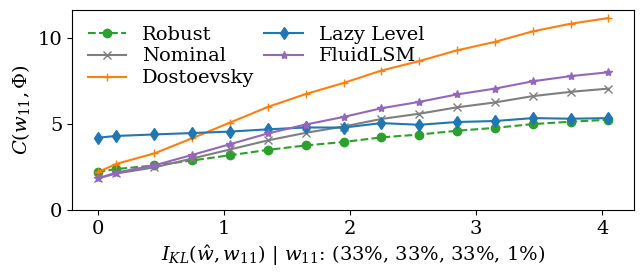

In [221]:
set_style(fsz=14)
df, _, fig, ax = create_and_plot(wls[11], samples)
ax.set_yticks([0, 5, 10])
ax.set_xticks([0, 1, 2, 3, 4])
set_size(fig, width=2*3.33, height=1.5*2)
save_fig(fig, 'w11_distance_cost.pdf')

[0.   0.15 0.45 0.75 1.05 1.35 1.65 1.95 2.25 2.55 2.85 3.15 3.45 3.75
 4.05]


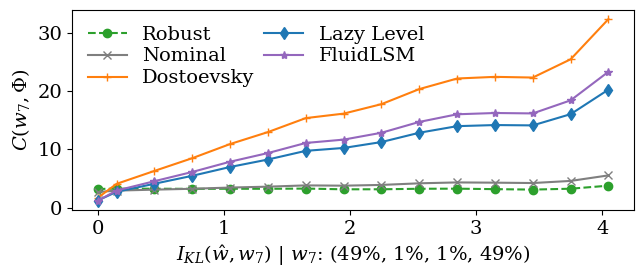

In [222]:
set_style(fsz=14)
df, _, fig, ax = create_and_plot(wls[7], samples)
ax.set_xticks([0, 1, 2, 3, 4])
set_size(fig, width=2*3.33, height=1.5*2)
save_fig(fig, 'w7_distance_cost.pdf')

In [131]:
designs = get_nominal_tunings(wls[11])
for key, val in designs.items():
    print(f'{key} : {val["design"]}')

Robust : [1.         5.58238483]
Nominal : [7.49214849 7.56058264]
Dostoevsky : [9.60901893 1.         1.00000004]
Lazy Level : [5.99804589 2.        ]
YZ : [8.50061904 8.59784001 1.         1.        ]


Hypothesis

H1: Flexible cost models provide best nominal performance (>=)

    - Only point read queries -> "True"
    - Write queries introdued -> True
    - Range queries introduced -> False

H2: Flexible cost models are inherently more robust

    - Only point read queries -> "False"
    - Write queries introdued -> False
    - Range queries introduced -> True

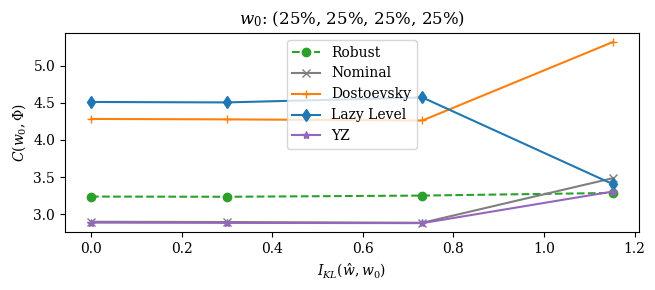

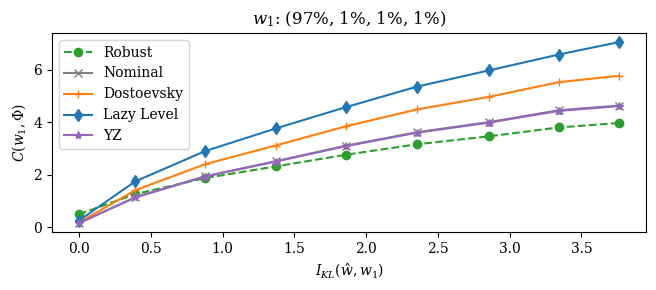

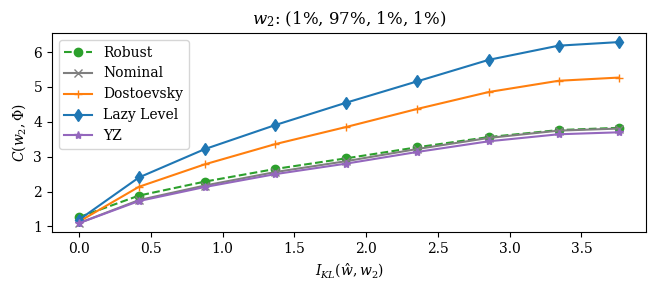

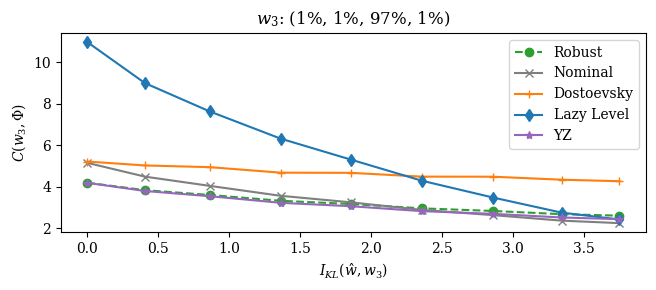

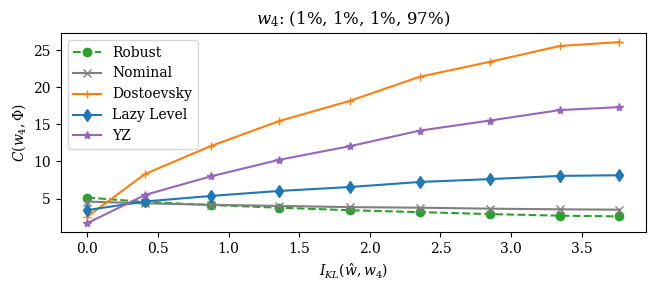

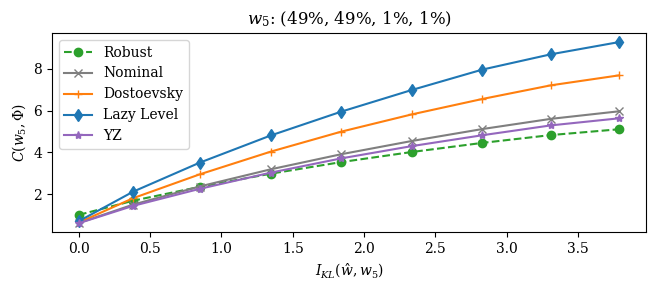

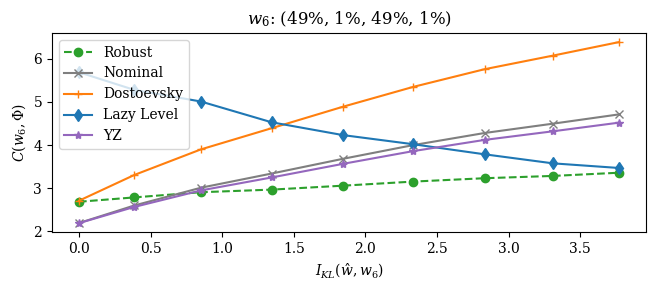

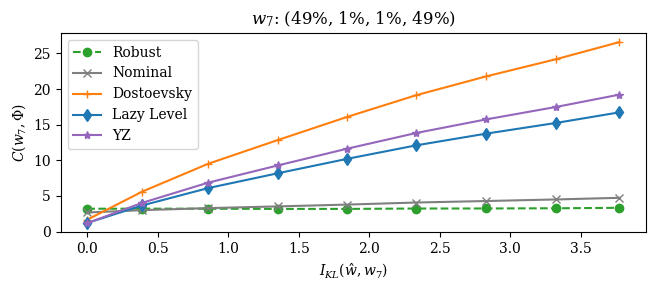

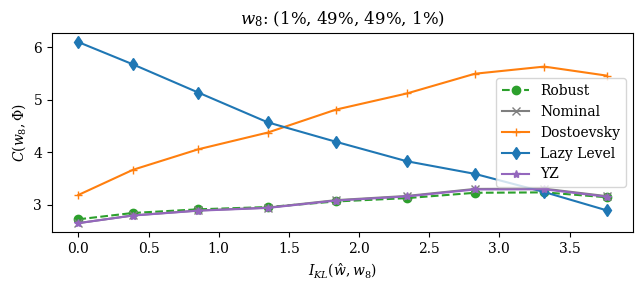

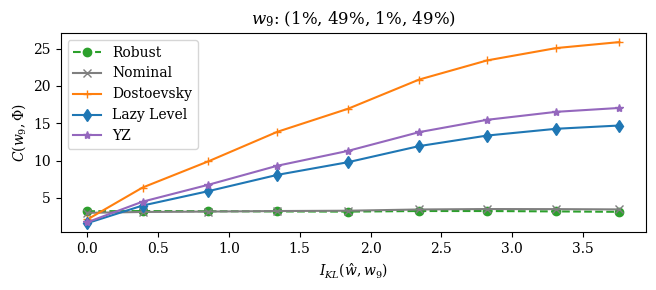

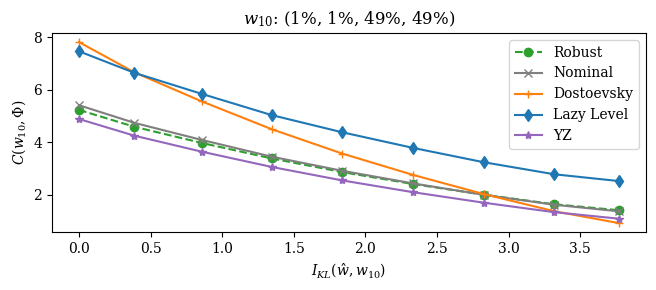

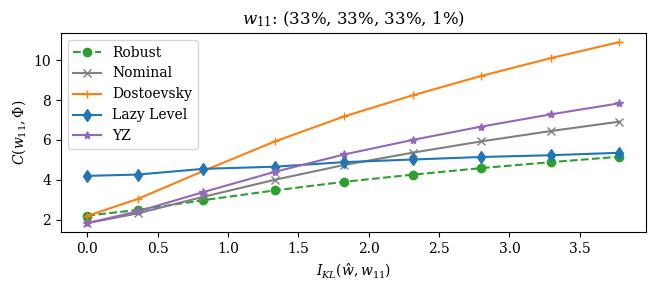

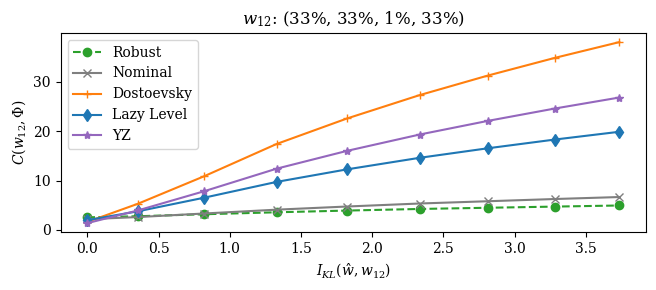

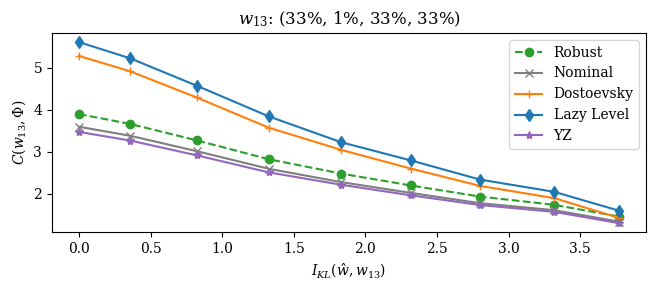

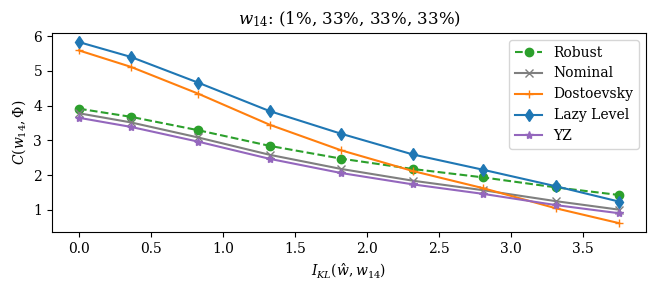

In [36]:
dfs = {}
for idx, workload in enumerate(wls):
    df, _, fig, ax = create_and_plot(workload, samples)
    set_size(fig, width=2*3.33, height=1.5*2)
    dfs[idx] = df
    # fig.savefig(f'wl_{idx}.pdf')

In [ ]:
# def plot_rw_graph(workload, samples, model='K'):
#     tuning = get_nominal_tuning(workload, model)
#     rw = [sum([sample[0], sample[1], sample[3]]) for sample in samples]
#     w0 = np.array([workload[key] for key in ('z0', 'z1', 'q', 'w')])
#     wl_id = workload['id']
#     rhos = [kl_div(sample, w0) for sample in samples]
#     cost = [tuning['solver'].nominal_objective(tuning['design'], sample[0], sample[1], sample[2], sample[3]) for sample in samples]

#     fig, ax = plt.subplots()
#     cmap = plt.get_cmap('viridis')
#     # norm = plt.Normalize(min(cost), max(cost))
#     # ax.scatter(rw, rhos, c=cmap(norm(cost)))
#     # norm = plt.Normalize(min(cost), max(cost))
#     # ax.scatter(rhos, rw, c=cmap(norm(cost)))
#     norm = plt.Normalize(min(rw), max(rw))
#     ax.scatter(rhos, cost, c=cmap(norm(rw)))
#     sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
#     sm.set_array([])
#     cbar = fig.colorbar(sm)
 
#     cbar.set_label('Group 1 Percentage')
#     ax.set_ylabel('$C(\phi)$')
#     ax.set_xlabel(f'I_{{KL}}($\hat{{w}}$, $w_{{{wl_id}}}$)')
#     ax.set_title(f'Model: {model}, '
#                  f'$w_{{{wl_id}}}$: ($z_0$: {w0[0]:.0%}, $z_1$: {w0[1]:.0%}, $q$: {w0[2]:.0%}, $w$: {w0[3]:.0%})')
#     return fig, ax

In [ ]:
# idx = 11
# for model in models:
#     old_fig, ax = plot_rw_graph(wls[idx], samples, model=model)